# **WGAN-GP for Knee X-Ray Generation**

In this notebook, we implement the training of a [WGAN-GP](https://arxiv.org/abs/1704.00028) (*Wasserstein Generative Adversarial Network with Gradient Penalty*). The goal of the model is to generate realistic images of knee X-rays, utilizing a [dataset](https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity) from Kaggle.

The notebook contains the necessary code to create and configure the WGAN-GP network, prepare the Kaggle dataset for training, preprocess the images, define evaluation metrics, train the model and generate new knee X-ray images. Additionally, the notebook includes techniques to monitor and visualize the model's progress during training.


# **Useful modules import**
First of all, it is necessary to import useful modules used during the tutorial.

### **Importing Required Libraries and Modules**

This code imports various libraries and modules necessary for data processing, model training, and evaluation:

- **`os`**: Interacts with the operating system for file and directory operations.
- **`cv2`**: Provides tools for image and video processing.
- **`random`**: Offers functions to generate random numbers.
- **`glob`**: Helps find file paths matching specific patterns.
- **`numpy (np)`**: Essential for numerical and scientific computing.
- **`time`**: Measures elapsed time, useful for tracking training duration.
- **`tqdm`**: Displays progress bars for loops.
- **`matplotlib.pyplot (plt)`**: Used for creating plots and visualizations.
- **`shutil`**: Facilitates high-level file operations such as copying and renaming.
- **`sklearn.model_selection.train_test_split`**: Splits datasets into training and test sets.
- **`tensorflow (tf)`**: Google’s machine learning library for building and training models:
  - **`tensorflow.keras`**: High-level API for model construction and training.
  - **`tensorflow.keras.layers`**: Contains various neural network layers.
  - **`tensorflow.keras.backend (K)`**: Provides backend functions for Keras.
  - **`tensorflow.keras.utils.to_categorical`**: Converts class vectors to binary class matrices.
  - **`tensorflow.keras.optimizers.Adam`**: Adam optimizer for training.
  - **`tensorflow.keras.optimizers.schedules.ExponentialDecay`**: Learning rate scheduler.
- **`keras.losses.binary_crossentropy`**: Loss function for binary classification tasks.
- **`google.colab.drive`**: Manages Google Drive access within Google Colaboratory.

Additionally, the code sets up TensorFlow to suppress logging and warnings, and ensures InceptionV3 weights are downloaded for later use.


In [1]:
import os
import random
import glob
import time
import shutil
import gc

import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.losses import binary_crossentropy

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import pickle
from scipy.stats import entropy

# Suppress TensorFlow logging
tf.get_logger().setLevel('ERROR')

# Suppress TensorFlow warnings
import warnings
warnings.filterwarnings('ignore')

# Download InceptionV3 weights at the beginning of your script
InceptionV3(include_top=False, weights='imagenet')
InceptionV3(include_top=True, weights='imagenet')

from google.colab import drive
drive.mount('/content/drive')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Mounted at /content/drive


### **Utility Functions**

This code defines several utility functions for image processing, visualization, and dataset management:

- **`plot_generated_images`**: Displays a grid of generated images with specified rows, columns, and figure size.
- **`plot_gan_losses`**: Plots the loss curves for both the discriminator and generator over epochs. It uses a dual-axis plot to show both losses.
- **`plot_fid_scores`**: Visualizes the FID (Fréchet Inception Distance) scores over epochs.
- **`plot_inception_scores`**: Plots the Inception Scores with error bars over epochs.
- **`countImages`**: Counts the number of images for each grade within a specified directory.
- **`searchForPairImgs`**: Finds and returns a pair of images from `test` and `auto_test` directories that match in name and side.
- **`selectRandomImgs`**: Selects random images from the training set for each grade, filtered by the specified side (right or left).
- **`plot_comparison_images`**: Plots original and modified images side-by-side for visual comparison.

These functions assist in visualizing results, managing datasets, and conducting image-based comparisons.


In [ ]:
def plot_generated_images(images, rows, cols, figsize=(10, 10)):
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.flatten()
    for img, ax in zip(images, axs):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


def plot_gan_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Discriminator loss', color='tab:blue')
    ax1.plot(d_losses, color='tab:blue', label='Discriminator')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Generator loss', color='tab:orange')
    ax2.plot(g_losses, color='tab:orange', label='Generator')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Generator and Discriminator Loss')
    plt.show()


def plot_fid_scores(fid_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score', color='tab:red')
    plt.xlabel('Epochs')
    plt.ylabel('FID Score')
    plt.title('FID Score Over Epochs')
    plt.legend()
    plt.show()


def plot_inception_scores(inception_scores, inception_stddevs):
    plt.figure(figsize=(10, 5))
    plt.errorbar(range(len(inception_scores)), inception_scores, yerr=inception_stddevs, fmt='-o', color='tab:green')
    plt.xlabel('Epochs')
    plt.ylabel('Inception Score')
    plt.title('Inception Score Over Epochs')
    plt.show()



def countImages(path):
  cont = [0] * 5

  for grades in range(5):
    cont[grades] = len(glob.glob(path + f'{grades}/*.png'))
  return cont


def searchForPairImgs():
    images = ['', '']
    while not all(images):
        random_grade = random.randint(0, 4)
        random_idx = random.randint(0, test[random_grade] - 1)
        img_test = glob.glob(f'/content/kneeKL299/test/{random_grade}/*.png')
        img_autotest = glob.glob(f'/content/kneeKL299/auto_test/{random_grade}/*.png')
        test_name = os.path.basename(img_test[random_idx])[:7]
        test_side = '1' if os.path.basename(img_test[random_idx])[7] == 'R' else '2'
        for img in img_autotest:
            if os.path.basename(img)[:-6] == test_name and os.path.basename(img)[8] == test_side:
                images = [img_test[random_idx], img]
    return images


def selectRandomImgs(side):
  return [random.choice([i for i in glob.glob(f"/content/kneeKL299/train/{grades}/*.png") if side in os.path.basename(i)]) for grades in range(5)]


def plot_comparison_images(original_images, modified_images, title_original='Original Image', title_modified='Modified Image'):
    num_images = min(len(original_images), len(modified_images))

    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        original_image = original_images[i].squeeze()
        modified_image = modified_images[i].squeeze()

        # Plot per le immagini originali
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_image, cmap='gray')
        plt.title(f'{title_original} {i + 1}')
        plt.axis('off')

        # Plot per le immagini modificate
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(modified_image, cmap='gray')
        plt.title(f'{title_modified} {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def plot_comparison_images(original_images, modified_images, title_original='Original Image', title_modified='Modified Image'):
    num_images = min(len(original_images), len(modified_images))

    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        original_image = original_images[i].squeeze()
        modified_image = modified_images[i].squeeze()

        # Plot per le immagini originali
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_image, cmap='gray')
        plt.title(f'{title_original} {i + 1}')
        plt.axis('off')

        # Plot per le immagini modificate
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(modified_image, cmap='gray')
        plt.title(f'{title_modified} {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# **Dataset**

The [**Knee Osteoarthritis**](https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity) dataset, containing X-ray images of knee joints with varying degrees of osteoarthritis severity, will be used.

The goal is to develop and train a deep generative model to generate images representing realistic knee X-rays.


## **Dataset download**

The following code loads the dataset into memory.


In [ ]:
# Install necessary libraries
!pip install kaggle
!pip install opendatasets
!pip install Pillow

In [ ]:
# Download the dataset
#!kaggle datasets download -d shashwatwork/knee-osteoarthritis-dataset-with-severity
!kaggle datasets download -d alessandromagnani99/knee-x-ray-osteoarthritis-dataset-with-kl-grading

# Unzip the dataset
!unzip -q /content/knee-x-ray-osteoarthritis-dataset-with-kl-grading.zip

# Remove the .zip file
!rm /content/knee-x-ray-osteoarthritis-dataset-with-kl-grading.zip

Dataset URL: https://www.kaggle.com/datasets/alessandromagnani99/knee-x-ray-osteoarthritis-dataset-with-kl-grading
License(s): Apache 2.0
100% 353M/354M [00:02<00:00, 151MB/s]
100% 354M/354M [00:02<00:00, 138MB/s]


## **Visualization**

This section visualizes a comparison of X-ray images categorized into the five KL grades. Each image is labeled with its respective KL grade from 0 to 4.


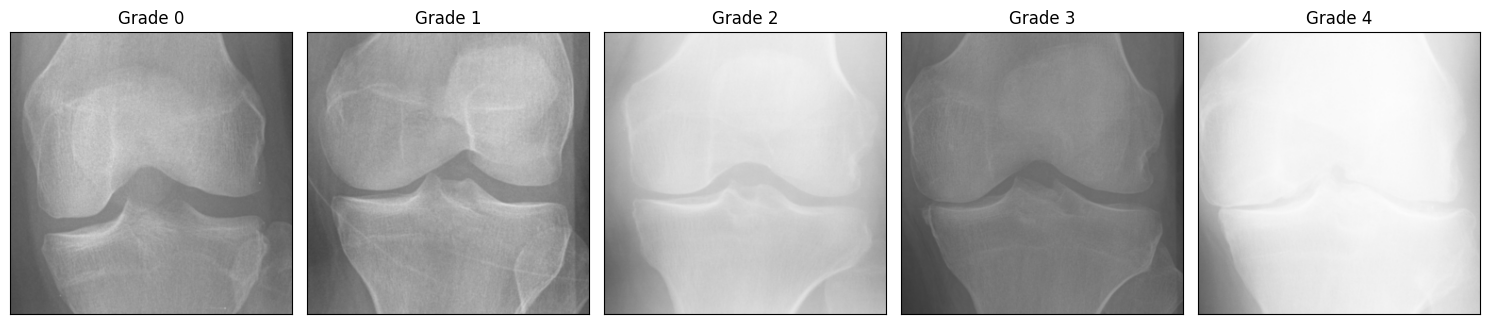

In [ ]:
# Parameter related to the 'side' of the knee. Possible values: L = Left | R = Right
side = 'L'

# Select 5 random images of the selected side.
selected_images = selectRandomImgs(side)
images = [cv2.imread(path) for path in selected_images]

# Create the structure to display the images
fig, axes = plt.subplots(1, 5, figsize=(15, 12))
for i in range(5):
  axes[i].imshow(images[i])
  axes[i].set_title(f'Grade {i}')
  axes[i].set_xticks([])
  axes[i].set_yticks([])

plt.tight_layout()
plt.show()

## **Dataset cardinality**
In the code cell below, the cardinality of the dataset is verified.

In [ ]:
num_classes = 2

train = countImages('/content/kneeKL299/train/')
val = countImages('/content/kneeKL299/val/')
test = countImages('/content/kneeKL299/test/')
auto_test = countImages('/content/kneeKL299/auto_test/')

print(f'Total cardinality of the train folder: {sum(train)}')
[print(f'   Images of grade {grades}: {train[grades]}') for grades in range(5)]
print('')
print(f'Total cardinality of the val folder: {sum(val)}')
[print(f'   Images of grade {grades}: {val[grades]}') for grades in range(5)]
print('')
print(f'Total cardinality of the test folder: {sum(test)}')
[print(f'   Images of grade {grades}: {test[grades]}') for grades in range(5)]
print('')
print(f'Total cardinality of the auto-test folder: {sum(auto_test)}')
[print(f'   Images of grade {grades}: {auto_test[grades]}') for grades in range(5)]
print('')

Total cardinality of the train folder: 5653
   Images of grade 0: 2229
   Images of grade 1: 1033
   Images of grade 2: 1483
   Images of grade 3: 739
   Images of grade 4: 169

Total cardinality of the val folder: 808
   Images of grade 0: 324
   Images of grade 1: 153
   Images of grade 2: 202
   Images of grade 3: 104
   Images of grade 4: 25

Total cardinality of the test folder: 1622
   Images of grade 0: 621
   Images of grade 1: 296
   Images of grade 2: 437
   Images of grade 3: 218
   Images of grade 4: 50

Total cardinality of the auto-test folder: 1526
   Images of grade 0: 604
   Images of grade 1: 275
   Images of grade 2: 403
   Images of grade 3: 200
   Images of grade 4: 44



Significant inconsistencies are immediately noticeable in the cardinalities of the 5 sub-folders related to different KL grades.

This inconsistency arises because only **a portion** of the images in **test** have undergone transformations, consequently: *Cardinality(test) > Cardinality(auto_test)*

In the cell below, a visual comparison is made to show the differences between **test** and **auto_test** images.

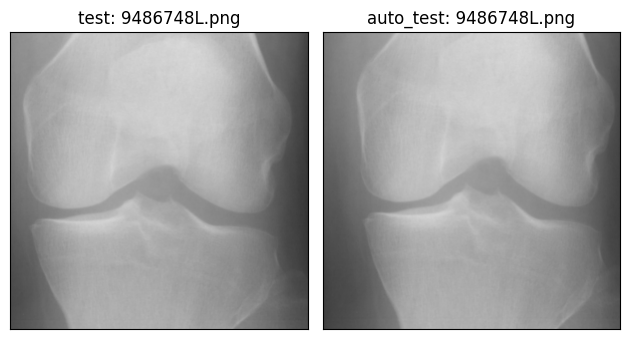

In [ ]:
# Searching for the image pair (test/auto_test)
path_test, path_autotest = searchForPairImgs()

# Loading the images
img_test = cv2.imread(path_test)
img_autotest = cv2.imread(path_autotest)

# Displaying the images
fig, axes = plt.subplots(1, 2)
for ax, img, title in zip(axes, [img_test, img_autotest], ['test', 'auto_test']):
    ax.imshow(img)
    ax.set_title(title + ': ' + os.path.basename(path_test))
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

We decided not to use the images in the **auto_test** folder for training. This choice was made to avoid overloading the training process in terms of memory usage, both RAM and GPU. Including transformed images in the training set could have significantly increased the memory requirements, potentially slowing down the training process and making it less efficient. Moreover, this could have led to the duplication of test images within the training set, which would undermine the integrity of the test evaluation and result in overfitting.



# **Creating Training, Validation and Test Sets**

The image paths have been organized into two categories representing two classes based on the KL grade (images of class 0 and 1 are grouped into the KL01 category, while images of class 2, 3, and 4 are grouped into the KL234 category).
The image paths are then shuffled for subsequent use.

In [ ]:
data_paths = ['/content/kneeKL299/train', '/content/kneeKL299/test', '/content/kneeKL299/val']

kl01_class_pairs = []
kl234_class_pairs = []

# Get image paths and classes within subdirectories
for data_path in data_paths:
    for sub_data_path in glob.glob(data_path + '/*'):
        class_name = sub_data_path.split('/')[-1]  # Extract class name from path

        image_paths = glob.glob(sub_data_path + '/*.png')

        # Check if any images were found
        if image_paths:
            for image_path in image_paths:
                # Map classes 0, 1 to class 0 and classes 2, 3, 4 to class 1
                if class_name in ['0', '1']:
                    kl01_class_pairs.append((image_path, '0'))
                elif class_name in ['2', '3', '4']:
                    kl234_class_pairs.append((image_path, '1'))

print("Classes in KL01:", set(class_name for _, class_name in kl01_class_pairs))
print("Number of images in KL01:", len(kl01_class_pairs))

print("Classes in KL234:", set(class_name for _, class_name in kl234_class_pairs))
print("Number of images in KL234:", len(kl234_class_pairs))

# Replace backslashes with forward slashes for consistency
kl01_class_pairs = [(path.replace('\\', '/'), cls) for path, cls in kl01_class_pairs]
kl234_class_pairs = [(path.replace('\\', '/'), cls) for path, cls in kl234_class_pairs]

# Shuffle the datasets
random.shuffle(kl01_class_pairs)
random.shuffle(kl234_class_pairs)

Classes in KL01: {'0'}
Number of images in KL01: 4656
Classes in KL234: {'1'}
Number of images in KL234: 3427


Division of the dataset into training, validation and test sets using the specified proportions. The number of samples for each set is calculated based on the provided proportions. Subsequently, the paths of the training images are split into three distinct sets: training, validation and test.

In [ ]:
# Separate the paths and classes for each dataset
kl01_image_paths, kl01_y = zip(*kl01_class_pairs)
kl234_image_paths, kl234_y = zip(*kl234_class_pairs)

print("KL01 dataset size:", len(kl01_image_paths))
print("KL234 dataset size:", len(kl234_image_paths))

print('Example KL01 image path:', kl01_image_paths[0])
print('Example KL01 class:', kl01_y[0])
print('Example KL234 image path:', kl234_image_paths[0])
print('Example KL234 class:', kl234_y[0])

KL01 dataset size: 4656
KL234 dataset size: 3427
Example KL01 image path: /content/kneeKL299/train/0/9303093R.png
Example KL01 class: 0
Example KL234 image path: /content/kneeKL299/train/4/9319367R.png
Example KL234 class: 1


# **Data preprocessing**

The code above loads images from specified paths (`kl01_train_image_paths`, `kl234_train_image_paths`, etc.), converts them to grayscale and then expands the dimensions of each image array to include a channel dimension using `np.expand_dims(..., axis=-1)`.

In [ ]:
# Upload the images and convert them to grayscale, adding a channel dimension
kl01_x = [np.expand_dims(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY), axis=-1) for image_path in kl01_image_paths]
kl01_x = np.array(kl01_x)
kl234_x = [np.expand_dims(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY), axis=-1) for image_path in kl234_image_paths]
kl234_x = np.array(kl234_x)


The addition of a channel dimension (`axis=-1`) is necessary because TensorFlow expects image data to have a channel dimension, even if it's grayscale. By adding this channel dimension, the image data becomes compatible with neural network models that expect input tensors of shape (height, width, channels), ensuring consistent data shape across different operations and layers of the model.

Therefore, our grayscale images have this shape: (299, 299), and to be compatible with the model, they need to have this shape: (299, 299, 1).

In [ ]:
print('KL01 data shape:', kl01_x.shape)
print('KL234 data shape:', kl234_x.shape)

KL01 data shape: (4656, 299, 299, 1)
KL234 data shape: (3427, 299, 299, 1)


## **Image horizontal flipping**

The function `is_right_oriented` is used to determine if an image is oriented to the right based on its file path. If an image is identified as right-oriented, it undergoes horizontal flipping.

Flipping ensures all images are uniformly oriented (left-oriented), which can enhance the accuracy of models like WGAN by facilitating consistent feature extraction and pattern recognition.


In [ ]:
# Function to determine if the image is right-oriented
def is_right_oriented(image_path):
    return image_path[-5] == 'R'

In [ ]:
kl01_x_flip = [cv2.flip(img, 1) if is_right_oriented(path) else img for img, path in zip(kl01_x, kl01_image_paths)]
kl234_x_flip = [cv2.flip(img, 1) if is_right_oriented(path) else img for img, path in zip(kl234_x, kl234_image_paths)]

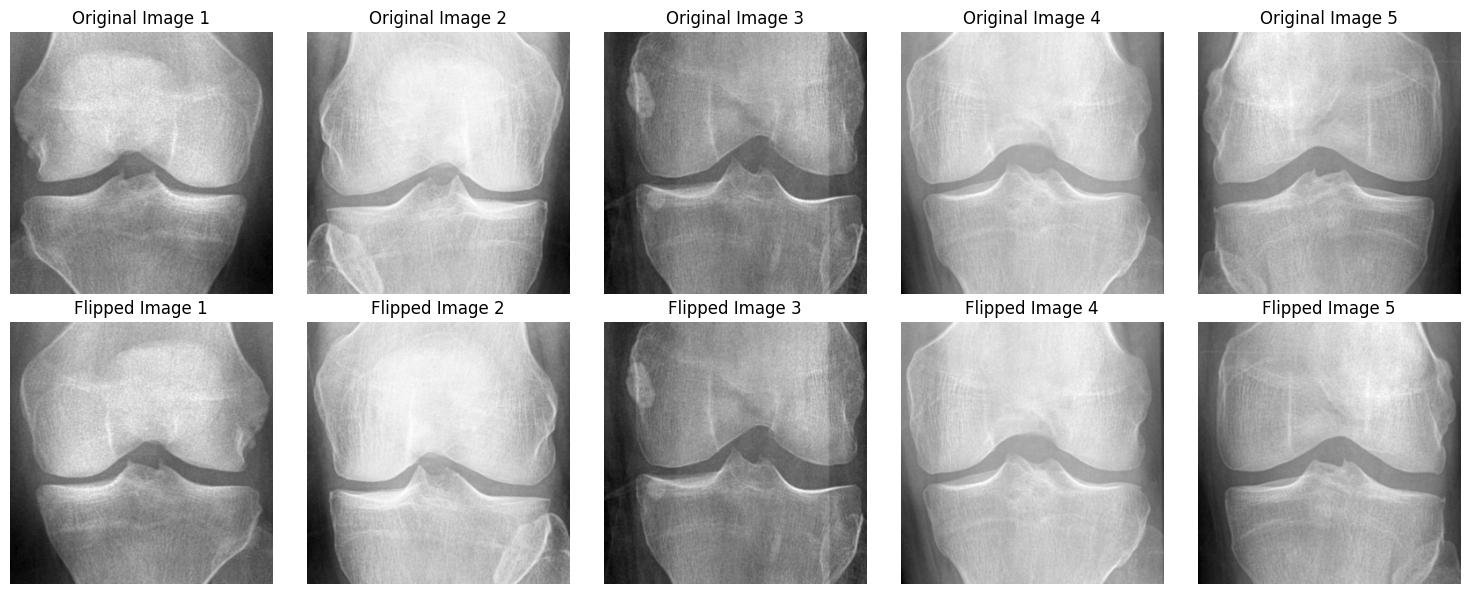

In [ ]:
# Displays the difference between the first 5 original and flipped images
plot_comparison_images(kl01_x[:5], kl01_x_flip[:5], title_original='Original Image', title_modified='Flipped Image')

## **Image equalization**

The function `equalize_image` is designed to enhance the contrast of images using histogram equalization. This technique aims to improve the visual quality of images by increasing the contrast and enhancing details that may be obscured due to poor lighting or exposure conditions.

This helps WGAN to detect and leverage subtle features more effectively.

In [ ]:
# Function definition to equalize images
def equalize_image(image):
    return cv2.equalizeHist(image)

In [ ]:
kl01_x_eq = np.array([equalize_image(image.squeeze()) for image in kl01_x_flip])
kl234_x_eq = np.array([equalize_image(image.squeeze()) for image in kl234_x_flip])

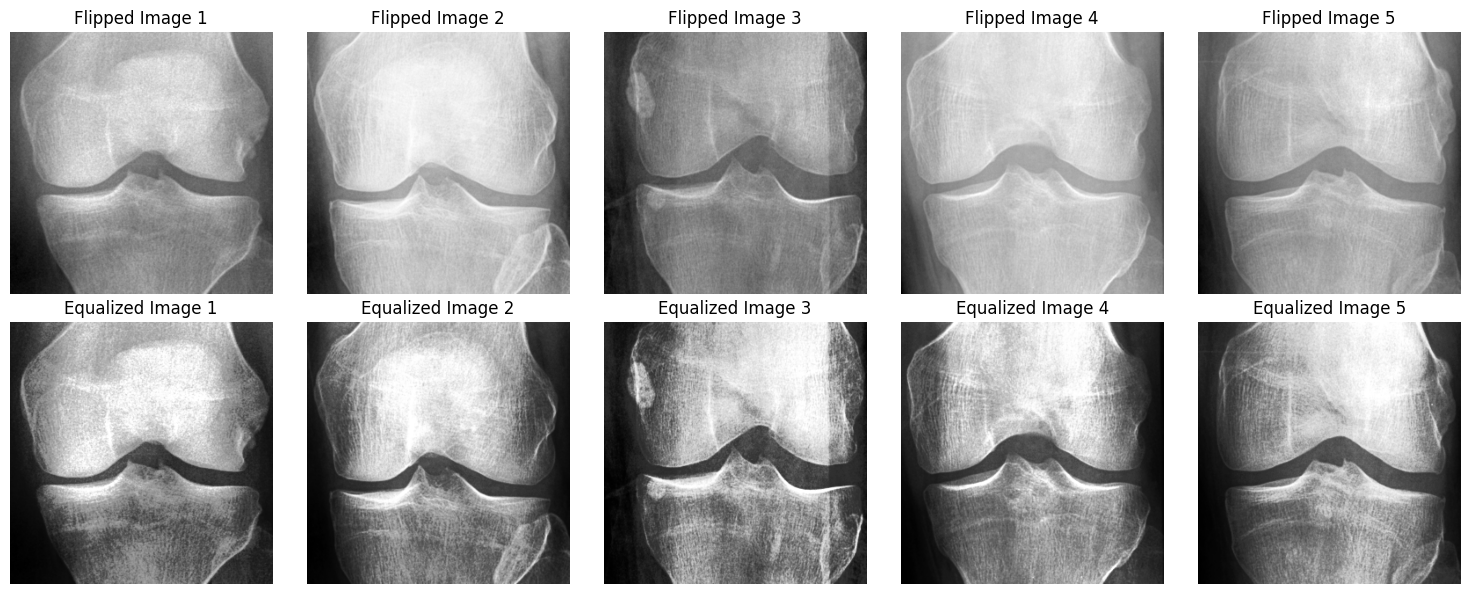

In [ ]:
# Display the difference between the first 5 flipped and equalized images
plot_comparison_images(kl01_x_flip[:5], kl01_x_eq[:5], title_original='Flipped Image', title_modified='Equalized Image')

## **Focus Filtering**

This code performs focus filtering on knee X-ray images using the Laplace kernel to calculate variances. Variances are computed for each group, and a threshold is set at the 50th percentile. Images with variances above the threshold are retained, while those below are discarded. Finally, statistics about the original and focused images are printed.

In [ ]:
from scipy.signal import convolve

# Focus filtering
laplace_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

def calculate_variances(images):
    return [np.var(np.abs(convolve(img.squeeze(), laplace_kernel))) for img in images]

# Calculate variances for both categories
kl01_variances = calculate_variances(kl01_x_eq)
kl234_variances = calculate_variances(kl234_x_eq)

# Calculate the variance threshold (50th percentile) for each category
kl01_threshold = np.percentile(kl01_variances, 50)
kl234_threshold = np.percentile(kl234_variances, 50)

In [ ]:
# Function to filter both images and labels
def filter_images_and_labels(images, labels, variances, threshold):
    filtered_images = []
    filtered_labels = []
    discarded_images = []
    discarded_labels = []
    for img, label, var in zip(images, labels, variances):
        if var >= threshold:
            filtered_images.append(img)
            filtered_labels.append(label)
        else:
            discarded_images.append(img)
            discarded_labels.append(label)
    return filtered_images, filtered_labels, discarded_images, discarded_labels

# Apply the filter to images and labels
kl01_x_focused, kl01_y_focused, kl01_x_discarded, kl01_y_discarded = filter_images_and_labels(kl01_x_eq, kl01_y, kl01_variances, kl01_threshold)
kl234_x_focused, kl234_y_focused, kl234_x_discarded, kl234_y_discarded = filter_images_and_labels(kl234_x_eq, kl234_y, kl234_variances, kl234_threshold)

# Convert to numpy arrays
kl01_x_focused = np.array(kl01_x_focused)
kl234_x_focused = np.array(kl234_x_focused)

In [ ]:
print("Statistiche KL01:")
print(f"Immagini originali: {len(kl01_x_eq)}, Immagini focalizzate: {len(kl01_x_focused)}")
print(f"Min variance: {min(kl01_variances):.3f}, Max variance: {max(kl01_variances):.3f}")
print(f"Mean variance: {np.mean(kl01_variances):.3f}, Threshold: {kl01_threshold:.3f}")

print("\nStatistiche KL234:")
print(f"Immagini originali: {len(kl234_x_eq)}, Immagini focalizzate: {len(kl234_x_focused)}")
print(f"Min variance: {min(kl234_variances):.3f}, Max variance: {max(kl234_variances):.3f}")
print(f"Mean variance: {np.mean(kl234_variances):.3f}, Threshold: {kl234_threshold:.3f}")

Statistiche KL01:
Immagini originali: 4656, Immagini focalizzate: 2328
Min variance: 208.974, Max variance: 2936.753
Mean variance: 494.834, Threshold: 502.609

Statistiche KL234:
Immagini originali: 3427, Immagini focalizzate: 1714
Min variance: 194.334, Max variance: 1236.104
Mean variance: 511.697, Threshold: 517.449


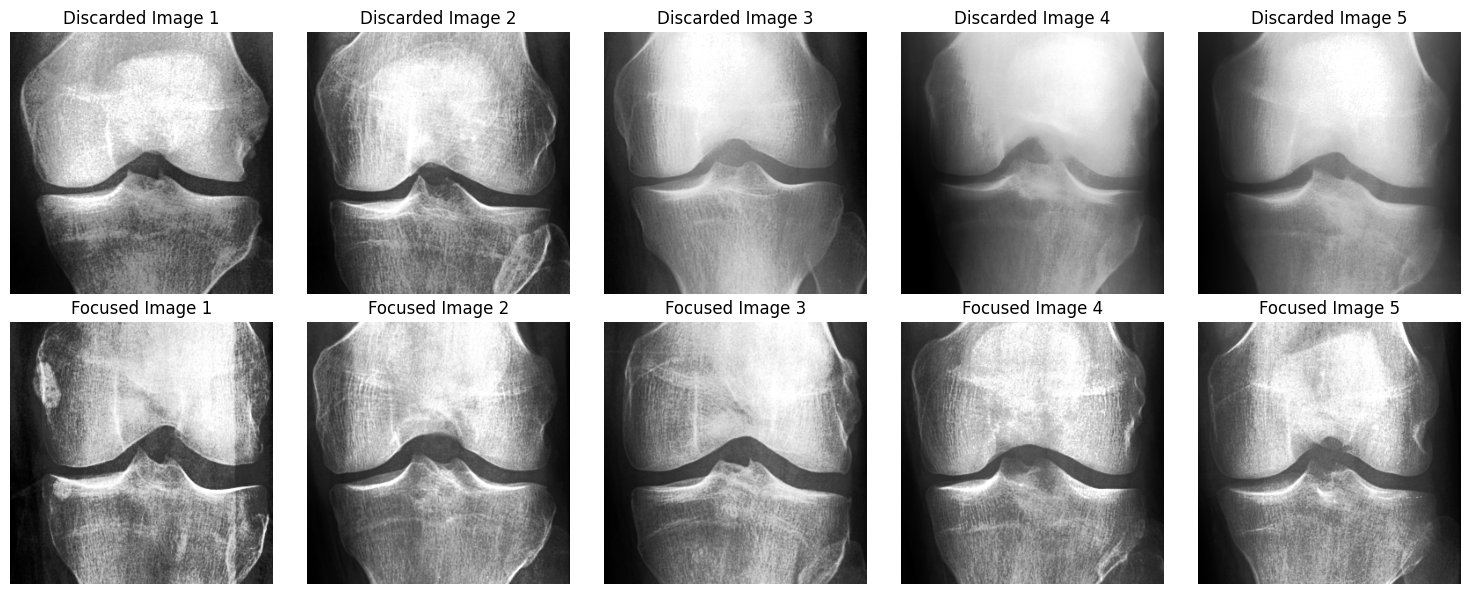

In [ ]:
# Visualizza la differenza tra le prime 5 immagini mantenute e scartate
plot_comparison_images(kl01_x_discarded[:5], kl01_x_focused[:5], title_original='Discarded Image', title_modified='Focused Image')

## **Intensity range normalization**
Pixel intensity is usually represented as discrete values in the range [0;255].

In [ ]:
print('KL01 Min value: ', kl01_x_focused.min())
print('KL01 Max value: ', kl01_x_focused.max())

print('KL234 Min value: ', kl234_x_focused.min())
print('KL234 Max value: ', kl234_x_focused.max())

KL01 Min value:  0
KL01 Max value:  255
KL234 Min value:  0
KL234 Max value:  255


Such values could produce math range errors with the activation function or make training unstable. To overcome these issues, a simple normalization step can be applied by dividing all values by 255 to get continuous values in the range [0;1].

In [ ]:
def normalize_data_in_batches(data, batch_size=32):
    num_samples = data.shape[0]
    normalized_data = np.zeros_like(data, dtype=np.float32)
    for i in range(0, num_samples, batch_size):
        batch = data[i:i+batch_size]
        normalized_batch = (batch / 127.5) - 1  # Normalize to range [-1, 1]
        normalized_data[i:i+batch_size] = normalized_batch
    return normalized_data

In [ ]:
# Normalize data in batches
kl01_x = normalize_data_in_batches(kl01_x_focused)
kl234_x = normalize_data_in_batches(kl234_x_focused)

In [ ]:
print('KL01 Min value: ', kl01_x.min())
print('KL01 Max value: ', kl01_x.max())

print('KL234 Min value: ', kl234_x.min())
print('KL234 Max value: ', kl234_x.max())

KL01 Min value:  -1.0
KL01 Max value:  1.0
KL234 Min value:  -1.0
KL234 Max value:  1.0


## **Label creation process**

The function assigns labels to indicate the classification of each sample in the dataset. If `is_kl01` is `True`, all labels will be set to 0.0; otherwise, they will be set to 1.0.


In [ ]:
def create_labels(num_labels, is_kl01):
    return np.full(num_labels, 0.0 if is_kl01 else 1.0, dtype=np.float32)

# Create labels
kl01_y = create_labels(len(kl01_x), True)   # All 0.0
kl234_y = create_labels(len(kl234_x), False)  # All 1.0

In [ ]:
print('KL01 label shape: ', kl01_y.shape)
print('KL234 label shape: ', kl234_y.shape)

KL01 label shape:  (2328,)
KL234 label shape:  (1714,)


# **Dataset Creation**

The `DataGenerator` class is used to generate batches of data for training. It processes images and labels, and provides a condition vector indicating whether the data belongs to the KL01 or KL234 class.

- **DataGenerator**: Takes images, labels, and a flag indicating if the data is from the KL01 dataset. It yields each image along with a condition vector: `[1.0, 0.0]` for KL01 and `[0.0, 1.0]` for KL234. It ensures that images with only 2 dimensions (grayscale) are expanded to 3 dimensions.

- **prepare_dataset**: Converts the `DataGenerator` into a TensorFlow dataset, handling:
  - **Shuffling**: Randomizes the order of the data with a buffer size of 1000.
  - **Batching**: Groups data into batches of the specified size, dropping incomplete batches if `drop_remainder=True`.
  - **Prefetching**: Improves performance by prefetching batches asynchronously.

- **Batch Size**: Set to 16 for creating the datasets.

Datasets are created for KL01 and KL234 classes and optionally combined into a single dataset. The combined dataset is shuffled with a buffer size equal to the total number of samples in both KL01 and KL234 datasets.



In [ ]:
class DataGenerator:
    def __init__(self, images, labels, is_kl01):
        self.images = images
        self.labels = labels
        self.is_kl01 = is_kl01

    def __call__(self):
        for image, label in zip(self.images, self.labels):
            if len(image.shape) == 2:
                image = np.expand_dims(image, axis=-1)
            condition = [1.0, 0.0] if self.is_kl01 else [0.0, 1.0]  # Condizione bidimensionale
            yield image, np.array(condition, dtype=np.float32)

In [ ]:
def prepare_dataset(images, labels, batch_size, is_kl01):
    generator = DataGenerator(images, labels, is_kl01)
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(2,), dtype=tf.float32)  # Modifica qui
        )
    )
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
batch_size = 16

# Create datasets
kl01_dataset = prepare_dataset(kl01_x, kl01_y, batch_size, is_kl01=True)
kl234_dataset = prepare_dataset(kl234_x, kl234_y, batch_size, is_kl01=False)

# Optional: Combine datasets if you want to train on both KL01 and KL234 together
combined_dataset = kl01_dataset.concatenate(kl234_dataset)

# Shuffle the combined dataset
combined_dataset = combined_dataset.shuffle(buffer_size=len(kl01_x) + len(kl234_x))

print("KL01 dataset:", kl01_dataset)
print("KL234 dataset:", kl234_dataset)
print("Combined dataset:", combined_dataset)

KL01 dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(16, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 2), dtype=tf.float32, name=None))>
KL234 dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(16, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 2), dtype=tf.float32, name=None))>
Combined dataset: <_ShuffleDataset element_spec=(TensorSpec(shape=(16, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 2), dtype=tf.float32, name=None))>


# **Wasserstein Generative Adversarial Network (WGAN)**
This section focuses on training a Wasserstein Generative Adversarial Network (WGAN) to generate images.


## **Model definition**

We have implemented the following function to create a Wasserstein Generative Adversarial Network (WGAN), an advanced variant of GANs.
WGAN introduces Wasserstein divergence as a loss metric, replacing the traditional cross-entropy used in standard GANs.



We chose to adopt the WGAN model because it is designed to ensure stability during training, avoiding common issues of traditional GANs such as mode collapse. Mode collapse was indeed the main issue in the initial approach with cDCGAN since the generator repeatedly produced the same type of output, reducing the diversity and variety of generated images and resulting in a constant loss of information as training progressed, with images in the final epochs being binary masks that only captured the knee outline.

Additionally, WGAN introduces a more robust loss metric (Wasserstein divergence) which we found leads to higher-quality generated images and faster model convergence.

The model design was inspired by well-established architectures as references, ensuring a solid foundation for our approach to image generation.

Below is an exemplary image of the model architecture:

![WGAN Model Architecture](https://www.researchgate.net/publication/358557860/figure/fig2/AS:1127682402205698@1645871844098/The-proposed-WGAN-model.png)


The generator consists of dense layers that expand random noise and additional information into a 3D tensor. It utilizes residual blocks during upsampling to preserve and enhance learned features.

In [ ]:
class SelfAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.gamma = self.add_weight(name='gamma', shape=[], initializer='zeros', trainable=True)

    def call(self, x):
        f = layers.Conv2D(self.channels // 8, 1, padding='same')(x)
        g = layers.Conv2D(self.channels // 8, 1, padding='same')(x)
        h = layers.Conv2D(self.channels, 1, padding='same')(x)

        s = tf.matmul(tf.reshape(g, [-1, g.shape[1]*g.shape[2], g.shape[-1]]),
                      tf.reshape(f, [-1, f.shape[1]*f.shape[2], f.shape[-1]]),
                      transpose_b=True)
        beta = tf.nn.softmax(s)
        o = tf.matmul(beta, tf.reshape(h, [-1, h.shape[1]*h.shape[2], h.shape[-1]]))
        o = tf.reshape(o, [-1, x.shape[1], x.shape[2], self.channels])

        return self.gamma * o + x

def build_generator(input_noise_dim, condition_dim):
    input_noise = layers.Input(shape=(input_noise_dim,), name='input_noise')
    input_condition = layers.Input(shape=(condition_dim,), name='input_condition')
    merged_input = layers.Concatenate(axis=1, name='generator_input')([input_noise, input_condition])

    x = layers.Dense(19 * 19 * 1024, use_bias=False)(merged_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((19, 19, 1024))(x)

    def residual_block(x, filters, use_attention=False):
        shortcut = x
        x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        if use_attention:
            x = SelfAttention()(x)
        return layers.Add()([shortcut, x])

    for i, filters in enumerate([512, 256, 128, 64]):
        x = layers.Conv2DTranspose(filters, 4, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        x = residual_block(x, filters, use_attention=(i==2))

    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 3, padding='same', activation='tanh')(x)

    generator_output = layers.Resizing(299, 299, interpolation="bilinear")(x)

    generator = Model([input_noise, input_condition], generator_output, name='generator')
    return generator


The discriminator evaluates the authenticity of images by comparing features extracted from input images with those from known real images.

In [ ]:
def build_discriminator(condition_dim):
    input_image = layers.Input(shape=(299, 299, 1), name='input_image')
    input_condition = layers.Input(shape=(condition_dim,), name='input_condition')

    condition_expansion = layers.Dense(299 * 299)(input_condition)
    condition_expansion = layers.Reshape((299, 299, 1))(condition_expansion)

    x = layers.Concatenate()([input_image, condition_expansion])

    def discriminator_block(x, filters, strides=2):
        x = layers.Conv2D(filters, 4, strides=strides, padding='same')(x)
        x = layers.LeakyReLU(0.2)(x)
        return x

    x = discriminator_block(x, 64)
    x = discriminator_block(x, 128)
    x = discriminator_block(x, 256)
    x = discriminator_block(x, 384)

    x = layers.Flatten()(x)
    x = layers.Dense(384)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(1)(x)

    discriminator = Model([input_image, input_condition], x, name='discriminator')
    return discriminator

## **Model creation**
Call the `build_generator` and `build_discriminator` functions to create the WGAN model.

In [ ]:
input_noise_dim = 100
num_classes = 2

# Build the models
wgan_gp_generator = build_generator(input_noise_dim, num_classes)
wgan_gp_discriminator = build_discriminator(num_classes)

## **Model visualization**
A string summary of the network can be printed using the [**summary**](https://keras.io/api/models/model/#summary-method) method.

In [ ]:
wgan_gp_generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_noise (InputLayer)    [(None, 100)]                0         []                            
                                                                                                  
 input_condition (InputLaye  [(None, 2)]                  0         []                            
 r)                                                                                               
                                                                                                  
 generator_input (Concatena  (None, 102)                  0         ['input_noise[0][0]',         
 te)                                                                 'input_condition[0][0]']     
                                                                                          

In [ ]:
wgan_gp_discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_condition (InputLaye  [(None, 2)]                  0         []                            
 r)                                                                                               
                                                                                                  
 dense_1 (Dense)             (None, 89401)                268203    ['input_condition[0][0]']     
                                                                                                  
 input_image (InputLayer)    [(None, 299, 299, 1)]        0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 299, 299, 1)          0         ['dense_1[0][0]'] 

The summary is useful for simple models, but can be confusing for complex models.

Function [**keras.utils.plot_model**](https://keras.io/api/utils/model_plotting_utils/) creates a plot of the neural network graph that can make more complex models easier to understand.

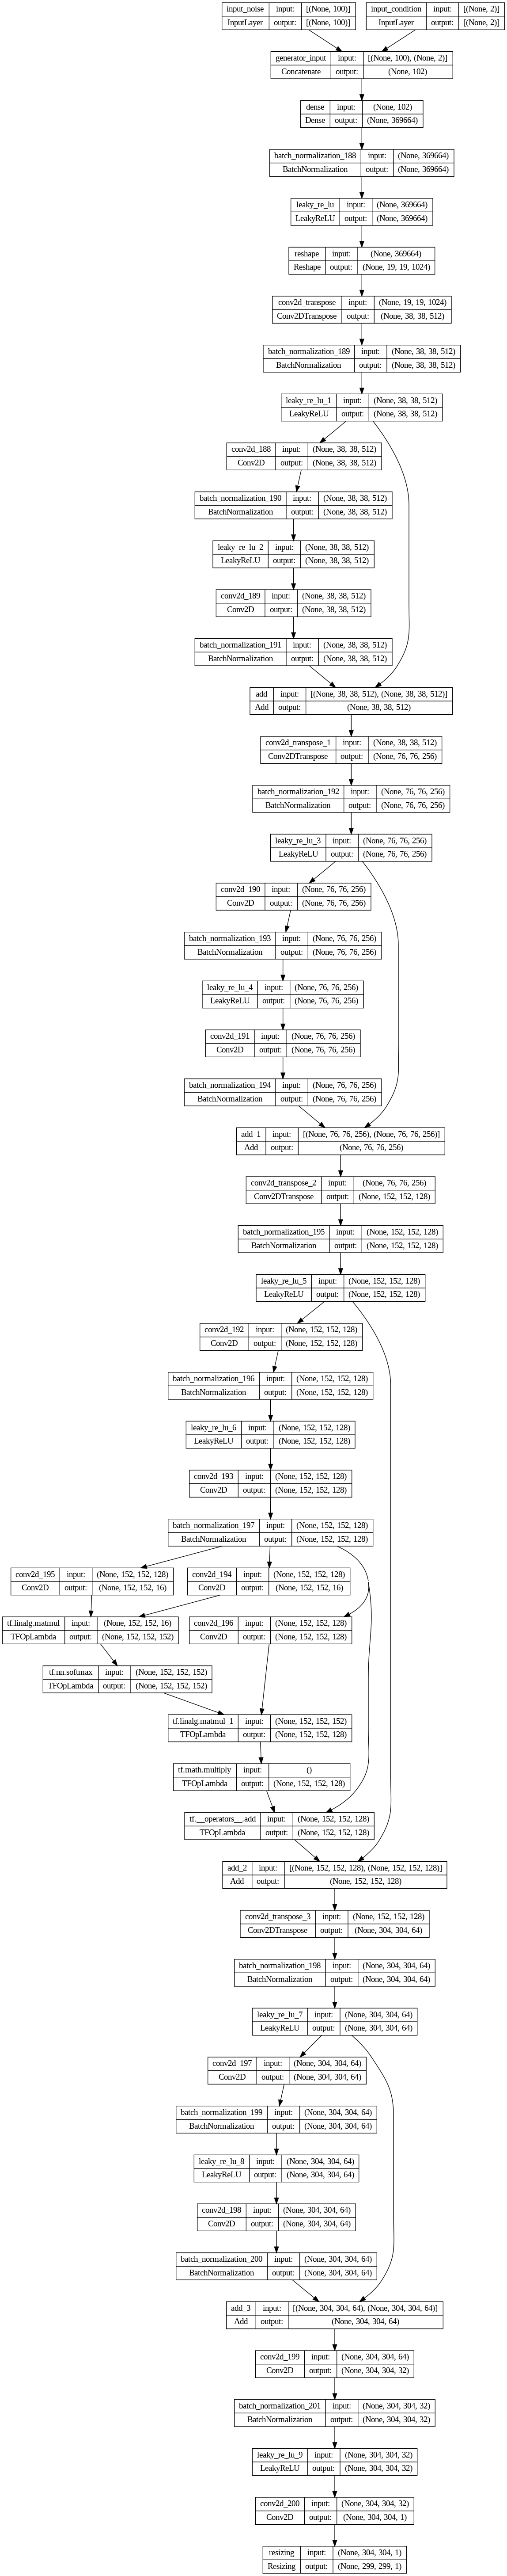

In [ ]:
# Remove and reinstall pydot and graphviz
!pip uninstall -y pydot > /dev/null 2>&1
!apt-get remove -y graphviz > /dev/null 2>&1

# Install pydot and graphviz
!pip install pydot > /dev/null 2>&1
!apt-get install -y graphviz > /dev/null 2>&1

# Configure the graphviz binary path
os.environ["PATH"] += os.pathsep + '/usr/bin/'  # Ensure the path is correct for your system

import pydot
import graphviz

# Import and visualize the TensorFlow Keras model
from tensorflow.keras.utils import plot_model
plot_model(wgan_gp_generator, show_shapes=True, show_layer_names=True, expand_nested=True)

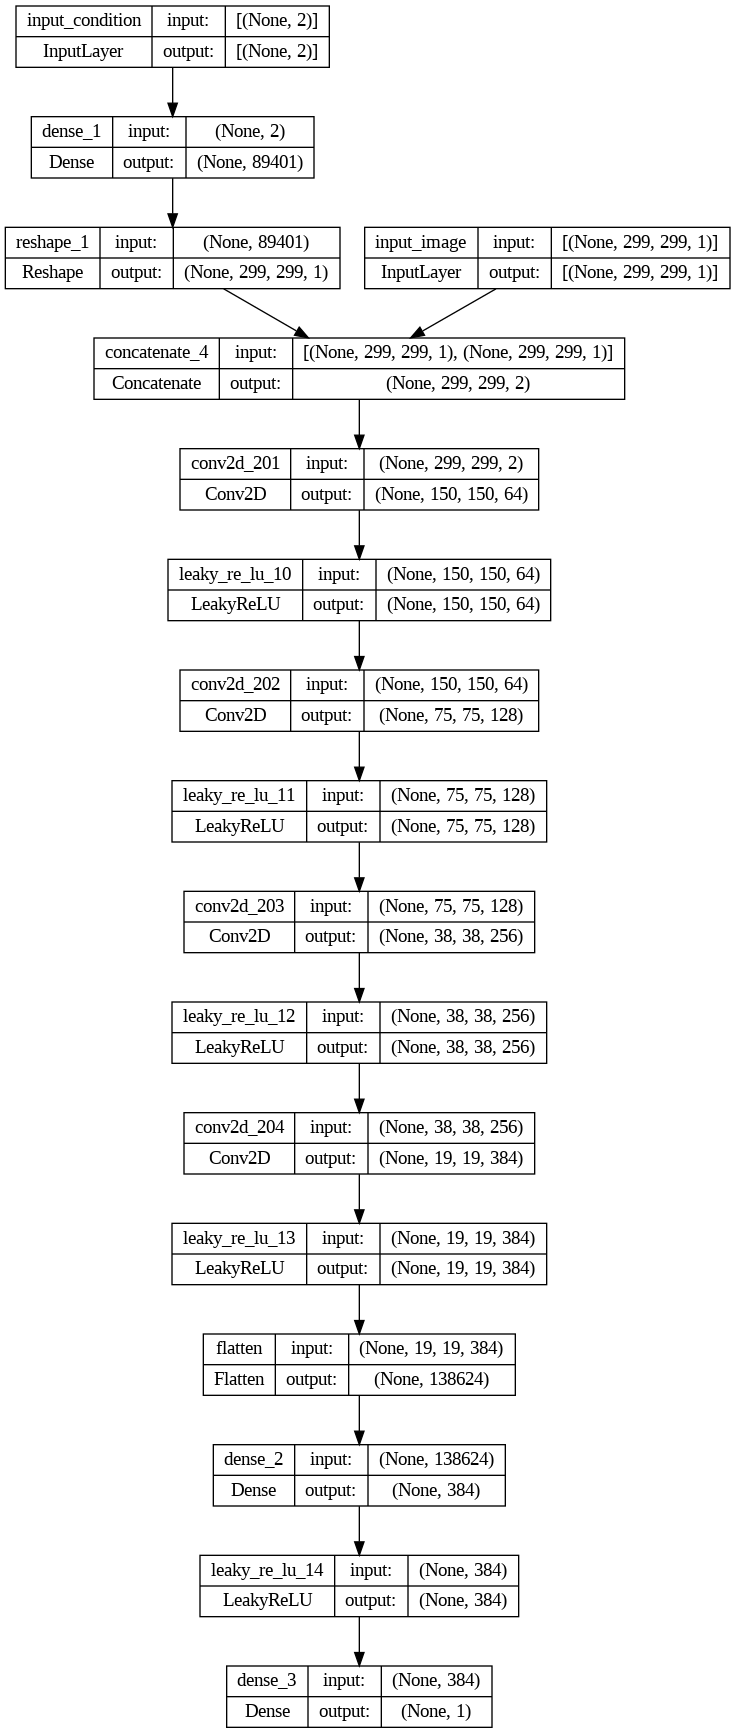

In [ ]:
plot_model(wgan_gp_discriminator, show_shapes=True, show_layer_names=True, expand_nested=True)

## **Model training**

### **Gradient penalty calculation**
The function `gradient_penalty` is defined, which computes the gradient penalty by interpolating between real and fake images, calculating the gradients, and measuring their deviation from a norm of 1.

In [ ]:
def gradient_penalty(discriminator, real_images, fake_images, conditions, batch_size):
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0., 1.)
    interpolated = alpha * real_images + (1 - alpha) * fake_images

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        interp_output = discriminator([interpolated, conditions], training=True)

    grads = gp_tape.gradient(interp_output, interpolated)
    grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean(tf.square(grad_norms - 1))
    return gp

### **Generation of fake batches**
The following code defines functions useful to generate batches of fake inputs for WGAN:
- `get_random_input_func` generates a tensor of random noise (`batch_size` x `noise_dim`) and corresponding one-hot encoded conditions (`batch_size` x `condition_dim`) to be used as input for a model.

  

In [ ]:
def get_random_input_func(batch_size, noise_dim, condition_dim):
    noise = tf.random.normal([batch_size, noise_dim])
    conditions = tf.random.uniform([batch_size], minval=0, maxval=condition_dim, dtype=tf.int32)
    conditions = tf.one_hot(conditions, depth=condition_dim)
    return noise, conditions

### **Image Resizing**

The function `resize_images` resizes a list of images to a `target_size` and normalizes them. It returns a NumPy array of resized images.


In [ ]:
def resize_images(images, target_size):
    resized_images = []
    for img in images:
        img_resized = tf.image.resize(img, target_size[:2])
        img_resized = img_resized / 255.0  # Normalize from [0, 255] to [0, 1]
        resized_images.append(img_resized)
    return np.array(resized_images)

### **Metrics Calculation**

In the context of training and evaluating generative models, it's crucial to measure the performance and quality of the generated outputs. The following functions are designed to calculate and manage various metrics:

- `calculate_fid`: Computes the Frechet Inception Distance (FID) between `real_images` and `generated_images`, indicating the similarity between the two datasets using a pre-trained InceptionV3 model.
- `calculate_inception_score`: Calculates the Inception Score for a set of images, which measures the quality and diversity of generated images using a pre-trained InceptionV3 model.
- `calculate_learning_rate`: Computes the learning rate based on initial learning rate, decay rate, and number of epochs trained.


In [ ]:
def calculate_fid(real_images, generated_images):
    # Load InceptionV3 model without the top layer for feature extraction
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Convert grayscale images to RGB
    if real_images.shape[-1] == 1:
        real_images = np.concatenate([real_images]*3, axis=-1)
    if generated_images.shape[-1] == 1:
        generated_images = np.concatenate([generated_images]*3, axis=-1)

    # Resize images and preprocess for InceptionV3
    real_images_resized = resize_images(real_images, (299, 299))
    generated_images_resized = resize_images(generated_images, (299, 299))
    real_images_preprocessed = preprocess_input(real_images_resized * 255.0)
    generated_images_preprocessed = preprocess_input(generated_images_resized * 255.0)

    # Extract features from both sets of images
    real_features = model.predict(real_images_preprocessed, verbose=0)
    generated_features = model.predict(generated_images_preprocessed, verbose=0)

    # Calculate mean and covariance of features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Compute FID score
    ssdiff = np.sum((mu_real - mu_generated)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_generated))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_generated - 2.0 * covmean)
    return fid

In [ ]:
def calculate_inception_score(images, batch_size=32, splits=10, epsilon=1e-16):
    # Load InceptionV3 model if not already loaded
    if not hasattr(calculate_inception_score, "model"):
        calculate_inception_score.model = InceptionV3(include_top=True, weights='imagenet', input_shape=(299, 299, 3))

    # Process and resize images
    processed_images = []
    for img in images:
        img = tf.image.resize(img, (299, 299))
        if img.shape[-1] == 1:
            img = tf.tile(img, [1, 1, 3])
        img = preprocess_input(img * 255.0)
        processed_images.append(img)
    processed_images = np.array(processed_images)

    # Predict class probabilities for batches of images
    preds = []
    n_batches = int(np.ceil(len(processed_images) / batch_size))
    for i in range(n_batches):
        batch = processed_images[i * batch_size:(i + 1) * batch_size]
        pred = calculate_inception_score.model.predict(batch, verbose=0)
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)

    # Compute Inception Score
    scores = []
    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        kl = part * (np.log(part + epsilon) - np.log(np.mean(part, axis=0) + epsilon))
        kl_sum = np.sum(kl, axis=1)
        kl_mean = np.mean(kl_sum)
        score = np.exp(kl_mean)
        scores.append(score)

    return np.mean(scores), np.std(scores)

In [ ]:
def calculate_learning_rate(initial_learning_rate, decay_rate, epochs_trained):
    return initial_learning_rate * (decay_rate ** epochs_trained)

### **Losses and Metrics Management**

These functions handle the saving and loading of training losses and evaluation metrics. They facilitate the persistence and retrieval of important data, such as discriminator and generator losses, as well as performance metrics like FID and Inception scores, ensuring that progress can be tracked and resumed effectively.


In [ ]:
def save_losses(d_losses, g_losses, checkpoint_dir):
    # Save discriminator and generator losses
    with open(os.path.join(checkpoint_dir, 'd_losses.pkl'), 'wb') as f:
        pickle.dump(d_losses, f)
    with open(os.path.join(checkpoint_dir, 'g_losses.pkl'), 'wb') as f:
        pickle.dump(g_losses, f)

def load_losses(checkpoint_dir):
    # Load discriminator and generator losses if they exist
    d_losses_path = os.path.join(checkpoint_dir, 'd_losses.pkl')
    g_losses_path = os.path.join(checkpoint_dir, 'g_losses.pkl')
    d_losses = pickle.load(open(d_losses_path, 'rb')) if os.path.exists(d_losses_path) else []
    g_losses = pickle.load(open(g_losses_path, 'rb')) if os.path.exists(g_losses_path) else []
    return d_losses, g_losses

def save_metrics(fid_scores, inception_scores, inception_stddevs, checkpoint_dir):
    # Save FID scores, Inception scores, and standard deviations
    with open(os.path.join(checkpoint_dir, 'metrics.pkl'), 'wb') as f:
        pickle.dump((fid_scores, inception_scores, inception_stddevs), f)

def load_metrics(checkpoint_dir):
    # Load metrics if they exist
    metrics_path = os.path.join(checkpoint_dir, 'metrics.pkl')
    if os.path.exists(metrics_path):
        with open(metrics_path, 'rb') as f:
            fid_scores, inception_scores, inception_stddevs = pickle.load(f)
    else:
        fid_scores = []
        inception_scores = []
        inception_stddevs = []
    return fid_scores, inception_scores, inception_stddevs

### **Batch Image Generation**

This function generates images in batches using a given `generator`. It takes `noise` and `conditions` as inputs and processes them in chunks of `batch_size` to produce a set of generated images, which are then concatenated into a single tensor.

**Note:** This batch processing approach is used to compute the Inception Score effectively. Previously, with fewer images (e.g., only 10 images), dividing them into 10 datasets resulted in comparisons based on just a single image. By generating images in batches, we ensure that enough data is available for meaningful comparison and avoid exhausting GPU resources.


In [ ]:
def generate_images_in_batches(generator, noise, conditions, batch_size=50):
    num_images = noise.shape[0]
    generated_images = []
    for i in range(0, num_images, batch_size):
        batch_noise = noise[i:i+batch_size]
        batch_conditions = conditions[i:i+batch_size]
        batch_generated = generator([batch_noise, batch_conditions], training=False)
        generated_images.append(batch_generated)
    return tf.concat(generated_images, axis=0)

### **Training Function for WGAN-GP**

This function trains a Wasserstein Generative Adversarial Network with Gradient Penalty (WGAN-GP) using TensorFlow and Keras. Key parameters include:
- `generator`: The generator model.
- `discriminator`: The discriminator model.
- `dataset`: The training dataset.
- `train_data_count`: Total number of examples in the training dataset.
- `input_noise_dim`: Dimensionality of the input noise vector for the generator.
- `epoch_count`: Number of training epochs.
- `batch_size`: Batch size for training.
- `get_random_input_func`: Function to generate random noise and conditions for the generator.
- `condition_count`: Dimension of additional conditional information (for conditional GANs).
- `n_critic`: Number of discriminator updates per generator update.
- `lambda_gp`: Weight parameter for the gradient penalty term.
- `initial_learning_rate`, `beta_1`, `beta_2`: Optimizer parameters for the Adam optimizer.
- `plt_frq`: Frequency of example image plotting and metric computation during training.
- `plt_example_count`: Number of example images to plot.
- `is_sample_count`, `is_batch_size`: Parameters for generating images and computing Inception Score.

During each epoch:
1. Loads previous losses and metrics if available.
2. Computes the current learning rate based on the epoch count.
3. Iterates through the dataset, performing multiple discriminator updates followed by a generator update.
4. Computes and stores epoch losses for both discriminator and generator.
5. Optionally generates images and computes FID and Inception scores at specified intervals, and plots example images.

Returns lists of epoch losses for the discriminator (`d_epoch_losses`) and generator (`g_epoch_losses`), along with FID scores, Inception scores, and their standard deviations.


In [ ]:
checkpoint_dir = '/content/drive/MyDrive/training'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
last_trained_epoch = 0

In [ ]:
def train_wgan_gp(generator, discriminator, dataset, train_data_count, input_noise_dim, epoch_count, batch_size, get_random_input_func, condition_count, checkpoint_dir, n_critic=5, lambda_gp=10, initial_learning_rate=0.0001, beta_1=0.5, beta_2=0.9, plt_frq=None, plt_example_count=10, is_sample_count=1000, is_batch_size=50):
    # Load previous losses and metrics if they exist
    d_epoch_losses, g_epoch_losses = load_losses(checkpoint_dir)
    fid_scores, inception_scores, inception_stddevs = load_metrics(checkpoint_dir)

    total_batches = train_data_count // batch_size

    # Compute the current learning rate based on the last trained epoch
    current_learning_rate = calculate_learning_rate(initial_learning_rate, 0.96, last_trained_epoch)
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=current_learning_rate, beta_1=beta_1, beta_2=beta_2)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=current_learning_rate, beta_1=beta_1, beta_2=beta_2)

    @tf.function
    def train_step(real_images, conditions):
        batch_size = tf.shape(real_images)[0]
        noise, noise_conditions = get_random_input_func(batch_size, input_noise_dim, condition_count)

        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            fake_images = generator([noise, noise_conditions], training=True)
            real_output = discriminator([real_images, conditions], training=True)
            fake_output = discriminator([fake_images, noise_conditions], training=True)

            d_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
            g_loss = -tf.reduce_mean(fake_output)

            # Gradient penalty
            alpha = tf.random.uniform([batch_size, 1, 1, 1], 0., 1.)
            interpolated = alpha * real_images + (1 - alpha) * fake_images

            with tf.GradientTape() as gp_tape:
                gp_tape.watch(interpolated)
                interp_output = discriminator([interpolated, conditions], training=True)

            grads = gp_tape.gradient(interp_output, interpolated)
            grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
            gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))

            d_loss += lambda_gp * gradient_penalty

        d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)

        discriminator_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
        generator_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

        return d_loss, g_loss

    for e in range(1, epoch_count + 1):
        start_time = time.time()

        d_losses = []
        g_losses = []

        # Calculate the actual number of batches in the dataset
        total_batches = sum(1 for _ in dataset)

        pbar = tqdm(enumerate(dataset), total=total_batches, desc=f'Epoch {last_trained_epoch + e}/{epoch_count}', unit='batch')
        for batch, (real_images, conditions) in pbar:
            for _ in range(n_critic):
                d_loss, _ = train_step(real_images, conditions)
                d_losses.append(d_loss)

            _, g_loss = train_step(real_images, conditions)
            g_losses.append(g_loss)

            # Update progress bar with average losses
            avg_d_loss = tf.reduce_mean(d_losses).numpy()
            avg_g_loss = tf.reduce_mean(g_losses).numpy()
            pbar.set_postfix({'D loss': f'{avg_d_loss:.4f}', 'G loss': f'{avg_g_loss:.4f}'})

        d_epoch_losses.append(tf.reduce_mean(d_losses))
        g_epoch_losses.append(tf.reduce_mean(g_losses))

        # Calculate FID and IS at the end of each epoch
        if plt_frq is not None and e % plt_frq == 0:
            # Generate images for plotting
            noise_to_plot, conditions_to_plot = get_random_input_func(plt_example_count, input_noise_dim, condition_count)
            generated_output_to_plot = generator([noise_to_plot, conditions_to_plot], training=False)
            generated_images_to_plot = (generated_output_to_plot + 1) / 2  # Denormalize to [0, 1]

            # Generate images in batches for Inception Score calculation
            noise_for_is, conditions_for_is = get_random_input_func(is_sample_count, input_noise_dim, condition_count)
            generated_output_for_is = generate_images_in_batches(generator, noise_for_is, conditions_for_is, is_batch_size)
            generated_images_for_is = (generated_output_for_is + 1) / 2  # Denormalize to [0, 1]

            # Calculate FID (assuming you want to use the plotted images for FID)
            fid_score = calculate_fid(real_images, generated_images_to_plot)
            print(f'FID Score at Epoch {last_trained_epoch + e}: {fid_score}')
            fid_scores.append(fid_score)

            # Calculate Inception Score using 1000 images
            inception_score, inception_std = calculate_inception_score(generated_images_for_is)
            print(f'Epoch {last_trained_epoch + e}, Inception Score: {inception_score} ± {inception_std}')
            inception_scores.append(inception_score)
            inception_stddevs.append(inception_std)

            # Plot only 10 images
            plot_generated_images(generated_images_to_plot, 1, plt_example_count)

        # Save generator and discriminator weights with a fixed name
        generator_path = os.path.join(checkpoint_dir, 'generator.h5')
        discriminator_path = os.path.join(checkpoint_dir, 'discriminator.h5')

        generator.save_weights(generator_path)
        discriminator.save_weights(discriminator_path)

        # Save losses
        save_losses(d_epoch_losses, g_epoch_losses, checkpoint_dir)

        # Save metrics
        save_metrics(fid_scores, inception_scores, inception_stddevs, checkpoint_dir)

    return d_epoch_losses, g_epoch_losses, fid_scores, inception_scores, inception_stddevs


### **Loading pre-trained weights**

This code attempts to load pre-trained weights for a generator (`wgan_gp_generator`) and discriminator (`wgan_gp_discriminator`) model from Google Drive. It specifies paths (`generator_weights_path` and `discriminator_weights_path`) where the weights are stored.

This functionality is currently commented out. Uncomment the code and execute it to load weights into the corresponding models.


In [ ]:
# Path to load weights on Google Drive
generator_weights_path = '/content/drive/MyDrive/training/generator.h5'
discriminator_weights_path = '/content/drive/MyDrive/training/discriminator.h5'

# Load weights if both files exist
if os.path.exists(generator_weights_path) and os.path.exists(discriminator_weights_path):
    wgan_gp_generator.load_weights(generator_weights_path)
    wgan_gp_discriminator.load_weights(discriminator_weights_path)
    print(f"Generator weights loaded from {generator_weights_path}")
    print(f"Discriminator weights loaded from {discriminator_weights_path}")
else:
    print("Weight files not found. No weights loaded.")

Weight files not found. No weights loaded.


### **Training Execution for Combined Datasets**

This code snippet initiates the training process for a Wasserstein Generative Adversarial Network with Gradient Penalty (WGAN-GP) on a combined dataset created from `kl01` and `kl234`. The training is executed using the `train_wgan_gp` function with the following parameters:

- `generator`: The WGAN-GP generator model.
- `discriminator`: The WGAN-GP discriminator model.
- `dataset`: Combined dataset derived from `kl01` and `kl234`.
- `train_data_count`: Total number of training examples in the combined dataset.
- `input_noise_dim`: Dimensionality of the input noise vector.
- `epoch_count`: Number of training epochs.
- `batch_size`: Batch size for training.
- `get_random_input_func`: Function to generate random input noise and conditions for the generator.
- `condition_count`: Number of conditions or classes (e.g., `2` for bidimensional conditions).
- `checkpoint_dir`: Directory for saving and loading model checkpoints.
- `n_critic`: Number of discriminator updates per generator update.
- `lambda_gp`: Gradient penalty coefficient.
- `initial_learning_rate`, `beta_1`, `beta_2`: Adam optimizer parameters.
- `plt_frq`: Frequency of plotting example images and computing metrics.
- `plt_example_count`: Number of images to plot for visual inspection.
- `is_sample_count`, `is_batch_size`: Parameters for generating images and computing the Inception Score.

The `train_wgan_gp` function trains the WGAN-GP model on the combined dataset, managing both training and evaluation processes.


Epoch 1/32: 100%|██████████| 252/252 [28:29<00:00,  6.78s/batch, D loss=1.3663, G loss=2.8322]


FID Score at Epoch 1: 36.61029073693593
Epoch 1, Inception Score: 1.0797088146209717 ± 0.00639872532337904


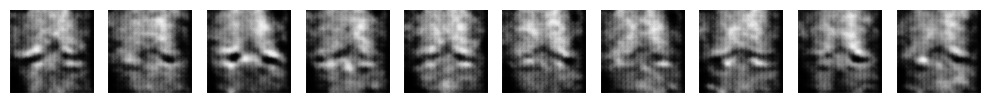

Epoch 2/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=1.4907, G loss=-2.7896]


FID Score at Epoch 2: 39.35185041322905
Epoch 2, Inception Score: 1.1234731674194336 ± 0.029861168935894966


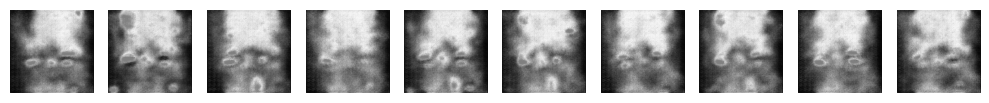

Epoch 3/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=5.3631, G loss=-8.4243]


FID Score at Epoch 3: 49.759918374873685
Epoch 3, Inception Score: 1.2554177045822144 ± 0.030965643003582954


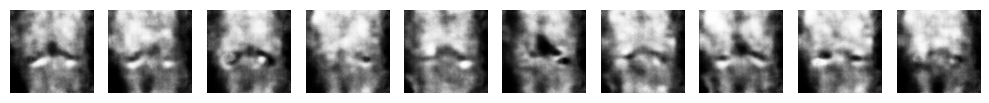

Epoch 4/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=2.5498, G loss=-9.6667]


FID Score at Epoch 4: 41.59413115519831
Epoch 4, Inception Score: 1.2686412334442139 ± 0.02200940251350403


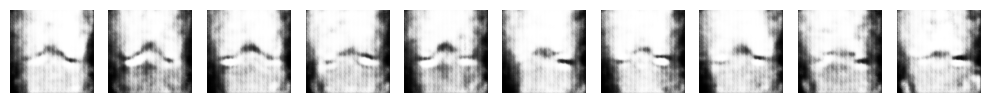

Epoch 5/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.9801, G loss=-6.4398]


FID Score at Epoch 5: 33.28895133675107
Epoch 5, Inception Score: 1.021098017692566 ± 0.006602018140256405


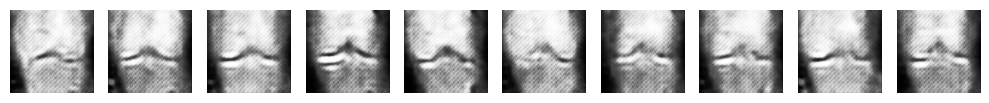

Epoch 6/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.9084, G loss=-7.3685]


FID Score at Epoch 6: 38.03567108011612
Epoch 6, Inception Score: 1.5849111080169678 ± 0.034469760954380035


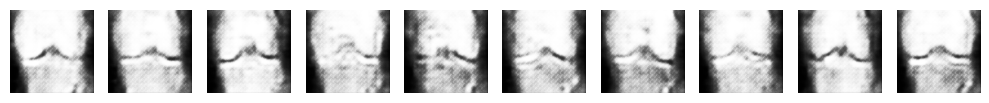

Epoch 7/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=0.6758, G loss=-6.6306]


FID Score at Epoch 7: 33.329308351414895
Epoch 7, Inception Score: 1.2306286096572876 ± 0.035213619470596313


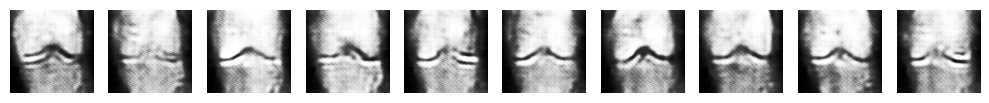

Epoch 8/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.4207, G loss=-6.4246]


FID Score at Epoch 8: 39.5649413429057
Epoch 8, Inception Score: 1.463228464126587 ± 0.02241595834493637


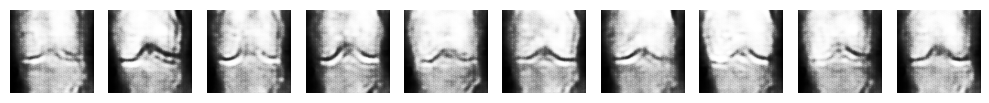

Epoch 9/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.5738, G loss=-8.2472]


FID Score at Epoch 9: 34.47379010120437
Epoch 9, Inception Score: 1.312941074371338 ± 0.04830336943268776


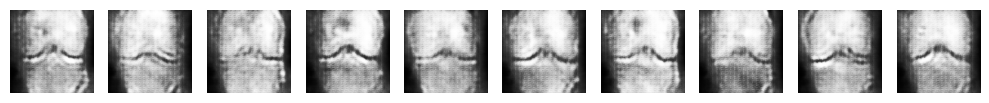

Epoch 10/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.8868, G loss=-7.5555]


FID Score at Epoch 10: 36.97158830348019
Epoch 10, Inception Score: 1.0049556493759155 ± 0.0007885086233727634


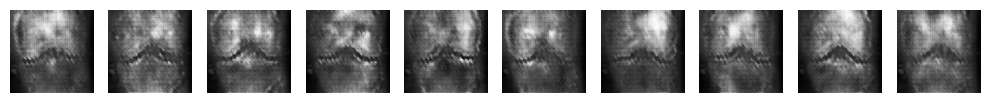

Epoch 11/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.5814, G loss=-7.7163]


FID Score at Epoch 11: 35.866954524482736
Epoch 11, Inception Score: 1.4336445331573486 ± 0.037239957600831985


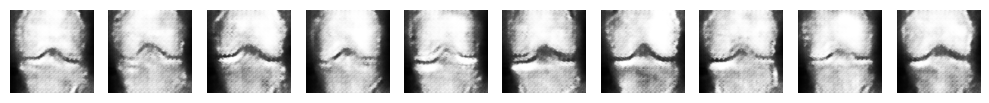

Epoch 12/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.5188, G loss=-7.5789]


FID Score at Epoch 12: 32.54533663324189
Epoch 12, Inception Score: 1.5714563131332397 ± 0.022430500015616417


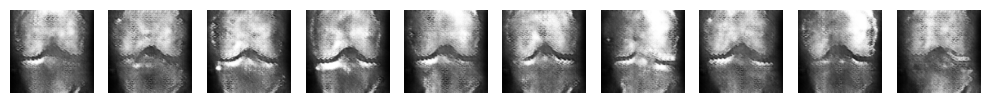

Epoch 13/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=0.3729, G loss=-7.2210]


FID Score at Epoch 13: 34.71142788745495
Epoch 13, Inception Score: 1.6834430694580078 ± 0.05495384335517883


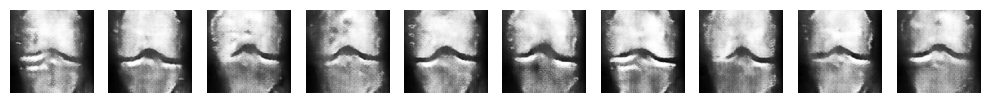

Epoch 14/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.4792, G loss=-7.1263]


FID Score at Epoch 14: 34.76678964892475
Epoch 14, Inception Score: 1.8480993509292603 ± 0.08281084150075912


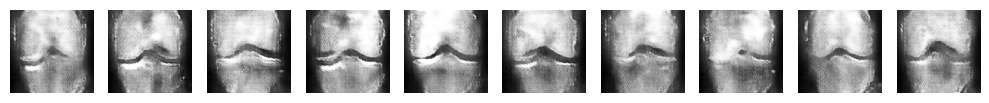

Epoch 15/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=0.5120, G loss=-7.4293]


FID Score at Epoch 15: 33.5286566992386
Epoch 15, Inception Score: 1.787298560142517 ± 0.05110108479857445


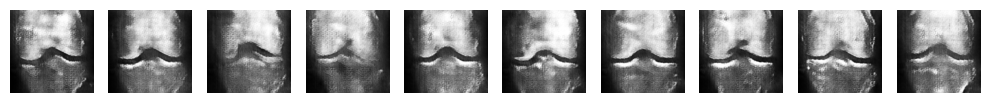

Epoch 16/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.4600, G loss=-7.6576]


FID Score at Epoch 16: 39.14640662776757
Epoch 16, Inception Score: 1.7352895736694336 ± 0.07248196750879288


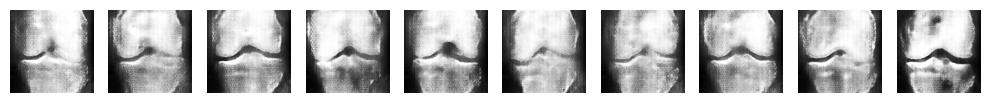

Epoch 17/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.4817, G loss=-8.3341]


FID Score at Epoch 17: 33.186802517599446
Epoch 17, Inception Score: 1.7202861309051514 ± 0.05738959088921547


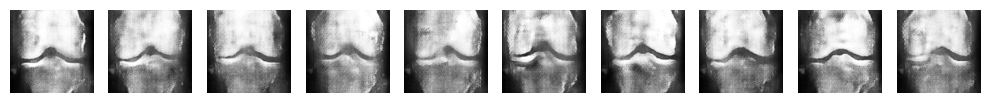

Epoch 18/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.4775, G loss=-8.1704]


FID Score at Epoch 18: 39.63887013510167
Epoch 18, Inception Score: 1.533555030822754 ± 0.03553672879934311


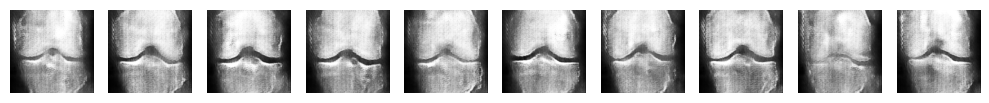

Epoch 19/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.7723, G loss=-9.6364]


FID Score at Epoch 19: 31.35789950797227
Epoch 19, Inception Score: 1.6915247440338135 ± 0.053958870470523834


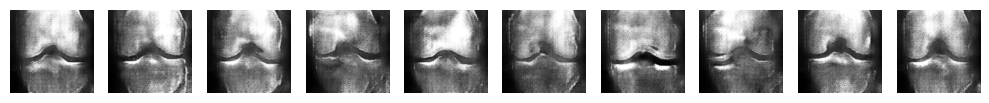

Epoch 20/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=0.3873, G loss=-9.8285]


FID Score at Epoch 20: 35.77089551920936
Epoch 20, Inception Score: 1.486548900604248 ± 0.053685255348682404


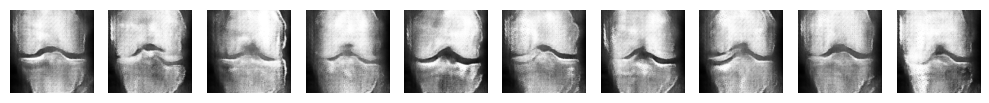

Epoch 21/32: 100%|██████████| 252/252 [27:49<00:00,  6.62s/batch, D loss=0.3884, G loss=-10.7438]


FID Score at Epoch 21: 39.733462076792804
Epoch 21, Inception Score: 1.6020991802215576 ± 0.04620545357465744


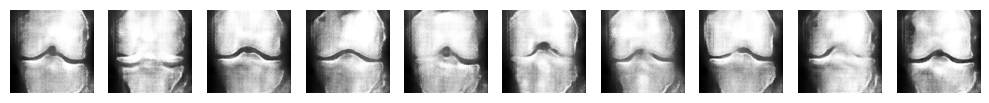

Epoch 22/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=0.3492, G loss=-11.3551]


FID Score at Epoch 22: 31.380235958978677
Epoch 22, Inception Score: 1.5030291080474854 ± 0.058149658143520355


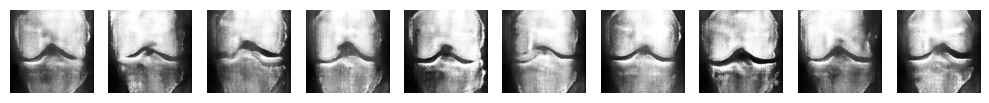

Epoch 23/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=0.3408, G loss=-11.7810]


FID Score at Epoch 23: 31.768367213379307
Epoch 23, Inception Score: 1.4940279722213745 ± 0.052520740777254105


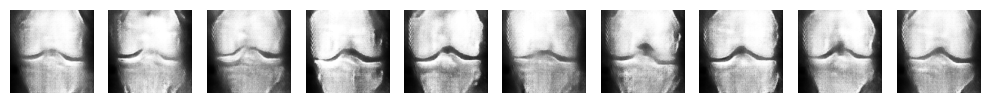

Epoch 24/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=0.2924, G loss=-12.1476]


FID Score at Epoch 24: 32.76998809140264
Epoch 24, Inception Score: 1.5720335245132446 ± 0.06289497017860413


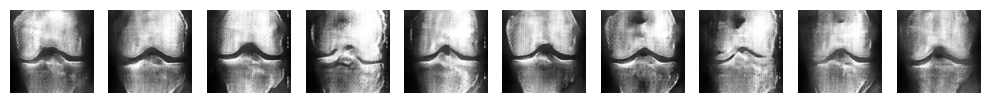

Epoch 25/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=0.2914, G loss=-13.6294]


FID Score at Epoch 25: 30.074138065253514
Epoch 25, Inception Score: 1.421373963356018 ± 0.037891827523708344


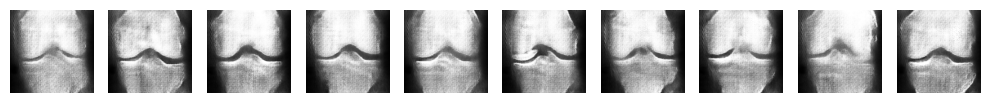

Epoch 26/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=0.1384, G loss=-14.0422]


FID Score at Epoch 26: 31.610958910536212
Epoch 26, Inception Score: 1.5497866868972778 ± 0.05341848358511925


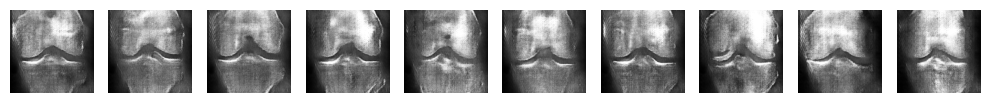

Epoch 27/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=-0.0876, G loss=-17.1564]


FID Score at Epoch 27: 28.553646900314206
Epoch 27, Inception Score: 1.5002572536468506 ± 0.047049038112163544


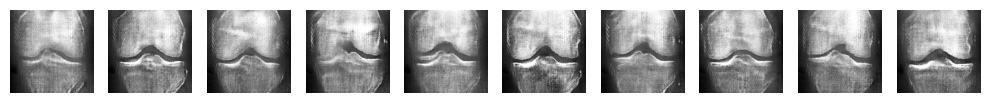

Epoch 28/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=-0.3158, G loss=-19.9267]


FID Score at Epoch 28: 27.68695161316819
Epoch 28, Inception Score: 1.6063642501831055 ± 0.04153281822800636


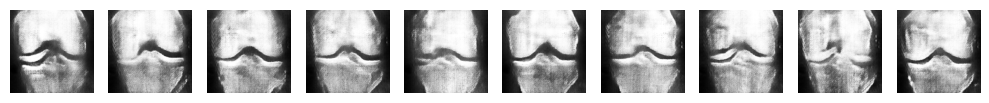

Epoch 29/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=-0.4969, G loss=-22.4621]


FID Score at Epoch 29: 28.794878706137
Epoch 29, Inception Score: 1.694641351699829 ± 0.060340628027915955


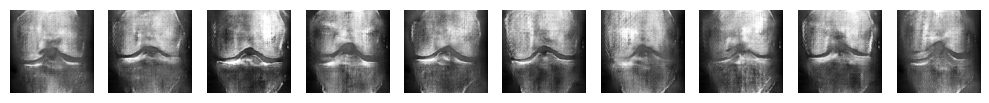

Epoch 30/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=-0.6708, G loss=-27.6456]


FID Score at Epoch 30: 39.641274349472106
Epoch 30, Inception Score: 1.6932878494262695 ± 0.087858647108078


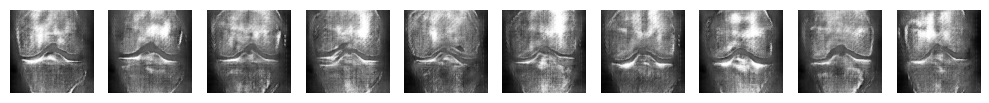

Epoch 31/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=-1.0025, G loss=-27.3669]


FID Score at Epoch 31: 38.99580155762176
Epoch 31, Inception Score: 1.7609012126922607 ± 0.07886563241481781


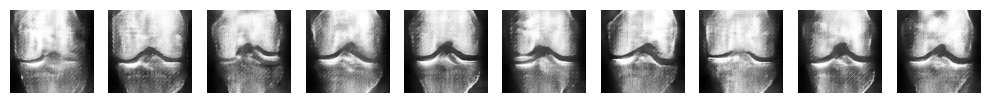

Epoch 32/32: 100%|██████████| 252/252 [27:48<00:00,  6.62s/batch, D loss=-0.2644, G loss=-32.5268]


FID Score at Epoch 32: 36.54097277378496
Epoch 32, Inception Score: 1.7028131484985352 ± 0.0431024432182312


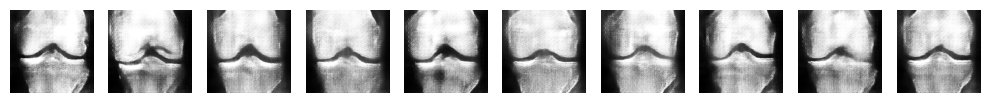

In [ ]:
# Calculate the total number of examples in the combined dataset
total_examples = len(kl01_x) + len(kl234_x)

combined_d_losses, combined_g_losses, fid_scores, inception_scores, inception_stddevs = train_wgan_gp(
    generator=wgan_gp_generator,
    discriminator=wgan_gp_discriminator,
    dataset=combined_dataset,
    train_data_count=total_examples,
    input_noise_dim=input_noise_dim,
    epoch_count=32,
    batch_size=batch_size,
    get_random_input_func=get_random_input_func,
    condition_count=2,  # Ora le condizioni sono bidimensionali
    checkpoint_dir=checkpoint_dir,
    n_critic=10,
    lambda_gp=15,
    initial_learning_rate=0.000001,
    beta_1=0.9,
    beta_2=0.99,
    plt_frq=1,
    plt_example_count=10,
    is_sample_count=1000,
    is_batch_size=50
)

### **Plotting GAN Results**

- **`plot_gan_losses`**: This function visualizes the trends of discriminator and generator losses over the epochs.

- **`plot_fid_scores`**: This function plots the Fréchet Inception Distance (FID) scores over the epochs, illustrating the evolution of the quality of the generated images.

- **`plot_inception_scores`**: This function displays the Inception Scores and their standard deviations over the epochs, indicating the diversity and quality of the generated images.


<Figure size 1000x500 with 0 Axes>

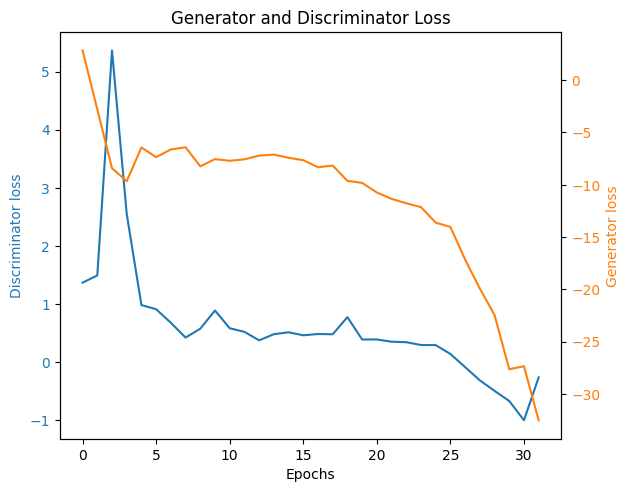

In [ ]:
plot_gan_losses(combined_d_losses, combined_g_losses)

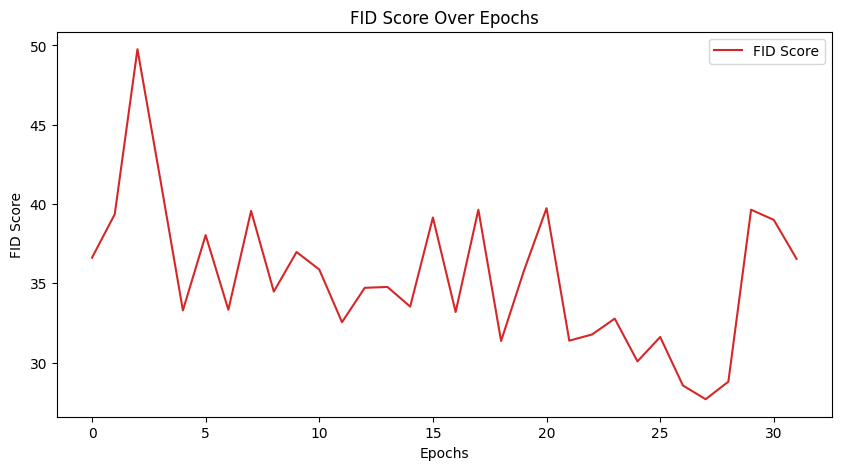

In [ ]:
plot_fid_scores(fid_scores)

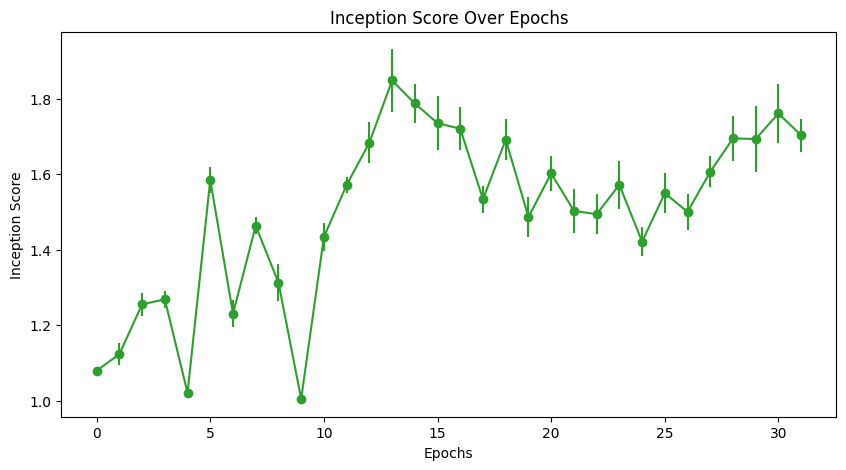

In [ ]:
plot_inception_scores(inception_scores, inception_stddevs)

### **Weight saving**

Demonstrates how to save the weights of a WGAN (Wasserstein Generative Adversarial Network) generator and discriminator to Google Drive.

Define paths for saving the model weights:
- `generator_weights_path`: Path to save generator weights.
- `discriminator_weights_path`: Path to save discriminator weights.

Use the `save_weights` method to save the generator (`wgan_gp_generator`) and discriminator (`wgan_gp_discriminator`) weights to their respective paths.

Saving weights ensures that the trained model parameters are persistently stored, facilitating easy reloading for inference or further training.


In [ ]:
generator_weights_path = '/content/drive/MyDrive/training/generator.h5'
discriminator_weights_path = '/content/drive/MyDrive/training/discriminator.h5'

# Save generator weights
wgan_gp_generator.save_weights(generator_weights_path)

# Save discriminator weights
wgan_gp_discriminator.save_weights(discriminator_weights_path)

# **Generated images**
The following code visualizes a randomly knee xray image (of a specific category: `label`) obtained calling the `predict` method of the generator.

In [ ]:
print("Forma dell'input del generatore:", wgan_gp_generator.input_shape)
print("Forma dell'output del generatore:", wgan_gp_generator.output_shape)

# Genera un'immagine di prova
noise = np.random.normal(0, 1, size=(1, input_noise_dim))
label = np.array([[1, 0]])  # KL01: [1, 0], KL234: [0, 1]
test_output = wgan_gp_generator.predict([noise, label])

print("Forma dell'output di test:", test_output.shape)
print("Valori min/max dell'output di test:", test_output.min(), test_output.max())

Forma dell'input del generatore: [(None, 100), (None, 2)]
Forma dell'output del generatore: (None, 299, 299, 1)
1/1 [==============================] - 1s 1s/step
Forma dell'output di test: (1, 299, 299, 1)
Valori min/max dell'output di test: -0.9981562 1.0



Generating image for class 0
Noise shape: (1, 100)
Label shape: (1, 2)
Generated image shape: (1, 299, 299, 1)
Generated image min/max values: -0.9982122 0.99993765
Reshaped image shape: (299, 299, 1)


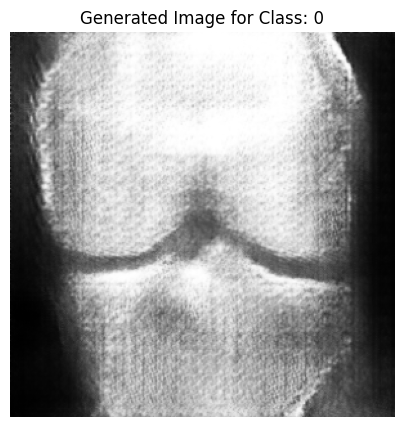

Image saved as 'generated_image_class_0.png'

Generating image for class 1
Noise shape: (1, 100)
Label shape: (1, 2)
Generated image shape: (1, 299, 299, 1)
Generated image min/max values: -0.9978843 0.9999688
Reshaped image shape: (299, 299, 1)


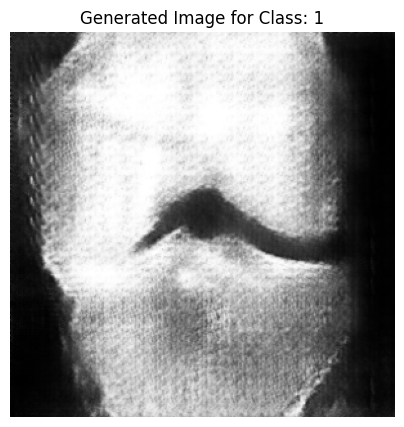

Image saved as 'generated_image_class_1.png'


In [ ]:
input_noise_dim = 100
num_classes = 2

# Generate noise and label for both classes
for class_label in range(num_classes):
    noise = np.random.normal(0, 1, size=(1, input_noise_dim))
    label = np.zeros((1, num_classes))
    label[0, class_label] = 1

    print(f"\nGenerating image for class {class_label}")
    print("Noise shape:", noise.shape)
    print("Label shape:", label.shape)

    # Generate image using separate inputs
    generated_x = wgan_gp_generator.predict([noise, label], verbose=0)

    print("Generated image shape:", generated_x.shape)
    print("Generated image min/max values:", generated_x.min(), generated_x.max())

    # Reshape the generated image
    original_image_shape = (299, 299, 1)
    digit = generated_x[0].reshape(original_image_shape)

    print("Reshaped image shape:", digit.shape)

    # Plot the generated image
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(digit.squeeze(), cmap='gray', vmin=-1, vmax=1)
    plt.title(f'Generated Image for Class: {class_label}')
    plt.show()

    # Save the image to a file
    plt.imsave(f'generated_image_class_{class_label}.png', (digit.squeeze() + 1) / 2, cmap='gray')
    print(f"Image saved as 'generated_image_class_{class_label}.png'")

Running the code below will show a row of randomly generated images for each classes (KL01 class and KL234 class).

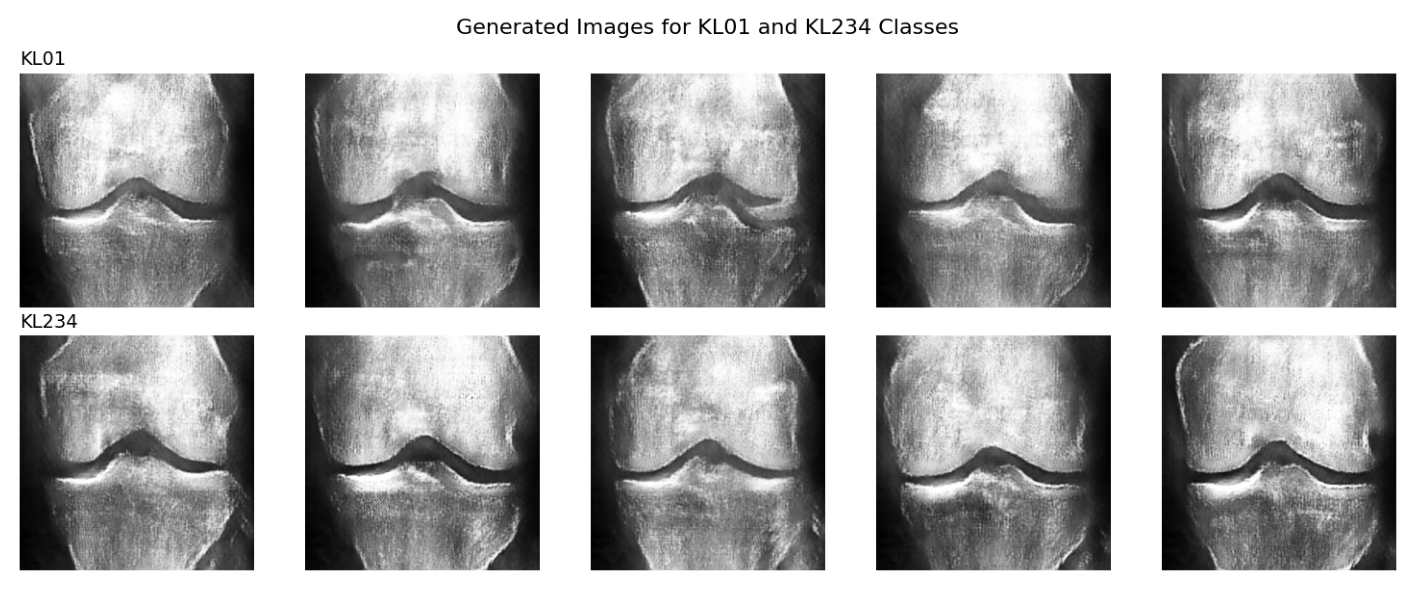

In [5]:
n = 5  # number of images per category
num_classes = 2  # KL01 and KL234
input_noise_dim = 100

generated_images = []
class_labels = ['KL01', 'KL234']

for class_label in range(num_classes):
    noise = np.random.normal(0, 1, size=(n, input_noise_dim))
    label_condition = np.zeros((n, num_classes))
    label_condition[:, class_label] = 1

    # Pass noise and condition as two separate inputs
    generated_x = wgan_gp_generator.predict([noise, label_condition], verbose=0)

    # Keep the images in the [-1, 1] range
    generated_images.append([g.squeeze().reshape(original_image_shape[0], original_image_shape[1]) for g in generated_x])

# Visualizzazione delle immagini generate
fig, axs = plt.subplots(num_classes, n, figsize=(n*3, num_classes*3))
fig.suptitle('Generated Images for KL01 and KL234 Classes', fontsize=16)

for i, class_images in enumerate(generated_images):
    for j, img in enumerate(class_images):
        axs[i, j].imshow(img, cmap='gray', vmin=-1, vmax=1)
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(f'{class_labels[i]}', fontsize=14, loc='left')

plt.tight_layout()
plt.show()

# Se vuoi salvare la figura
plt.savefig('generated_kl_images.png', dpi=300, bbox_inches='tight')
print("Image saved as 'generated_kl_images.png'")

In [ ]:
# Dopo aver generato le immagini
print("Shape of an image:", generated_images[0][0].shape)
print("Min and max values:", np.min(generated_images[0][0]), np.max(generated_images[0][0]))
print("Shape of generated_x:", generated_x.shape)
print("Shape of g:", generated_x[0].shape)

Shape of an image: (299, 299)
Min and max values: -0.99830705 0.99954385
Shape of generated_x: (5, 299, 299, 1)
Shape of g: (299, 299, 1)
